<center><img src=img/MScAI_brand.png width=70%></center>

# Graph Search

### Depth-first traversal

As we probably know, **depth-first traversal** means starting at some node, and traversing outward recursively until we can't go any further, and then backtracking.

In [1]:
import networkx as nx
G = nx.DiGraph()
# eg "ab" means edge (a, b)
G.add_edges_from(["ab", "ac", "bd", "be"])  

<img src="img/tree.png" width=20%>

There are two variants, depth-first *preorder* and depth-first *postorder*.

<img src="img/tree.png" width=20%>

In [2]:
def depth_first_preorder(G, n): # start at node n in graph G
    yield n # this is a generator
    for m in G[n]:
        # generator recursion!
        yield from depth_first_preorder(G, m) 
list(depth_first_preorder(G, "a"))

['a', 'b', 'd', 'e', 'c']

<img src="img/tree.png" width=20%>

In [3]:
def depth_first_postorder(G, n):
    for m in G[n]:
        yield from depth_first_postorder(G, m)
    yield n
list(depth_first_postorder(G, "a"))

['d', 'e', 'b', 'c', 'a']

The above is just traversal. If we want to actually search, the user can do it:

In [4]:
for n in depth_first_postorder(G, "a"):
    if n == "d":
        print("I found it!")

I found it!


### Trees versus Graphs

Recall that a tree is a graph without cycles. Our depth-first examples above used trees, but they're defined for graphs in general. (Same for breadth-first, below.)

However, in the case of a graph we have to be careful not to revisit a node. Below is one way to do this for the case of *depth-first preorder* traversal.

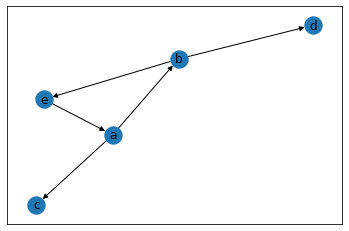

In [5]:
G = nx.DiGraph()
G.add_edges_from(["ab", "ac", "bd", "be", "ea"])
nx.draw_networkx(G)

In [6]:
def depth_first_preorder_graph(G, n):
    visited = set() 
    # make a *closure*, a fn which has access to `visited`
    def _helper(G, n):
        if n in visited: return # don't re-visit!
        yield n
        visited.add(n)
        for m in G[n]:
            yield from _helper(G, m)
    yield from _helper(G, n) # use our closure
    
list(depth_first_preorder_graph(G, "a"))    

['a', 'b', 'd', 'e', 'c']

### Breadth-first search

As we probably know, **breadth-first traversal** means starting at some node, and traversing outward one "level" at a time.

**Breadth-first search** means searching for a particular node (or a node with some particular property), using breadth-first traversal.

<img src="img/tree.png" width=20%>

The best way to implement breadth-first search is using a queue.

In [7]:
from collections import deque # double-ended queue

In [8]:
G = nx.DiGraph()
# let's make G a tree again, ie no cycles
G.add_edges_from(["ab", "ac", "bd", "be"])  

In [9]:
def breadth_first(G, n):
    queue = deque([n])
    while len(queue):
        n = queue.popleft()
        yield n
        queue.extend(G[n]) # ie all nodes reachable from n
list(breadth_first(G, "a"))

['a', 'b', 'c', 'd', 'e']

### Flexibility

We wrote our depth-first and breadth-first algorithms as generators, because they `yield`ed each node as they visited it. This is a nice flexible way to work, because it allows the user to call a function for each node. But depending on the application, we might need to write them differently.

Also, we assumed that the graph was a NetworkX graph, but in some applications we might use a different graph format, and then we would change the code to access the successors as appropriate.

### Shortest-path problem and Dijkstra's algorithm

<center><img src=img/tigh_neachtain_map.png width=40%></center>

A practical problem: what is the shortest path from one location to another, via a network of roads?

Our graph is a set of streets, where each street links two junctions; and each street has a **weight** telling us how long it would take to travel along that street.

This is a **shortest-path problem**. It is a **generalisation** of the simple breadth-first search setting, where every edge effectively has a weight of 1. We add an entire "level" all at once because all nodes in that level can be visited in 1 more time-step.

**Dijkstra's shortest-path algorithm** which solves this problem is like a generalisation of breadth-first search.

We maintain a list of visited nodes including the length of time required to reach each node (starting from the start). At each step, we find the unvisited node which can be reached most quickly, and add that. 

Implementation is a bit more tricky as it requires a priority queue.

A few lines from our data file:

```
#i,j,d
A,B,10
A,C,15
A,D,25
```

In [10]:
import pandas as pd
df = pd.read_csv("data/cities.csv", skiprows=1, 
                 names=["i", "j", "d"])

In [11]:
df.head()

,i,j,d
0,A,B,10
1,A,C,15
2,A,D,25
3,B,C,10
4,C,D,17


In [12]:
G = nx.Graph()
for idx, row in df.iterrows():
    i, j, d = row
    G.add_edge(i, j, weight=d)

NetworkX has some *layout* algorithms built-in. Let's try one to make a picture of this imaginary country.

In [13]:
pos = nx.kamada_kawai_layout(G)

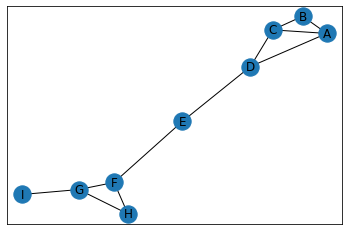

In [14]:
nx.draw_networkx(G, pos=pos)

Now we're ready to run Dijkstra's algorithm. 

In [15]:
nx.dijkstra_path(G, "A", "H")

['A', 'D', 'E', 'F', 'H']

In [16]:
nx.dijkstra_path_length(G, "A", "H")

100

### Searching an infinite graph

"A calculator has only 3 buttons. The first multiplies the current value by 3, the second adds 2 and the third subtracts 2. Starting with 0 what is the least number of presses you need to reach 100?"

-- https://puzzling.stackexchange.com/questions/91090/three-button-calculator

This is a *shortest-path* problem in a graph. Every integer is a node, and e.g. there is an edge from 0 $\rightarrow$ 2 because we can press the `+2` button. However, the graph is infinite, so we can't just create it and then use a shortest-path algorithm. A solution is to use breadth-first search, creating the graph as we go using a custom `moves` function.

In [17]:
def bfs_generative(start, target, moves):
    """If the graph is infinite, we can still use BFS!
    `start` is a node, `target` is a node, and now
    `moves(n)` gives the possible moves from a node `n`.
    """
    if start == target: return [start] # special case
    back_pointers = {} # "how did we get here?"
    queue = deque([start])
    while len(queue):
        n = queue.popleft()
        for m in moves(n):
            if m in back_pointers: continue # avoid re-visit
            queue.append(m)
            back_pointers[m] = n # store the edge
            if m == target:
                return reconstruct(back_pointers, start, target)

In [18]:
def reconstruct(back_pointers, start, target):
    """A helper function to create the path from start to 
    target. We use the backward pointers and create the 
    backward path, then reverse."""
    result = [target]
    while target != start:
        target = back_pointers[target] # iterate back
        result.append(target) # store each node
    result.reverse()
    return result

In [19]:
# now solve the three-button calculator problem
start = 0
target = 100
moves = lambda x: (x*3, x+2, x-2)
bfs_generative(start, target, moves)

[0, 2, 4, 12, 36, 34, 102, 100]

We can use the same code for many other problems, such as the famous *farmer, wolf, goat and cabbage* problem.

"A farmer went to a market and purchased a wolf, a goat, and a cabbage. On his way home, the farmer came to the bank of a river and rented a boat. But crossing the river by boat, the farmer could carry only himself and a single one of his purchases: the wolf, the goat, or the cabbage.

If left unattended together, the wolf would eat the goat, or the goat would eat the cabbage.

The farmer's challenge was to carry himself and his purchases to the far bank of the river, leaving each purchase intact."

This is really a (small) finite graph, but if we have to create the whole graph by hand we'll have solved the problem already, so it would be nicer to solve it using our generative BFS.

We can encode a state as `(L, R)` where `L` is the `set` of items on the left bank and `R` the `set` of items on the right bank. The challenge is to write the `moves` function.